<a href="https://colab.research.google.com/github/DiegoPaiz8/IA_IB_DiegoPaiz/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

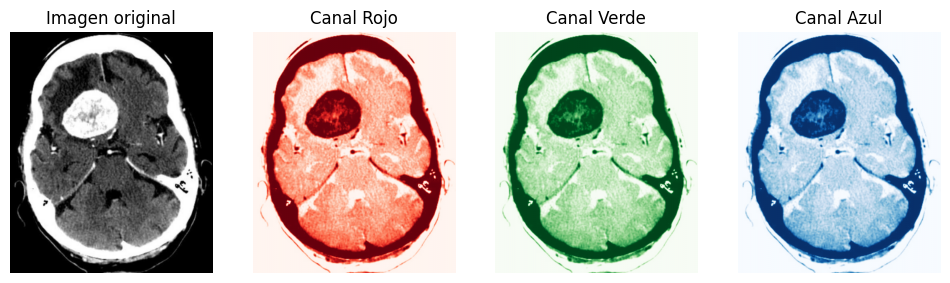

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Cargar imagen a color
img = cv2.imread('/content/tumor.jpg')

# Verificacion d eimagen acrgada
if img is None:
    print("Error: No se pudo cargar la imagen. Por favor, verifica la ruta del archivo.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Separar canales
    R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

    # Mostrar los canales por separado
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title('Imagen original')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(R, cmap='Reds')
    plt.title('Canal Rojo')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(G, cmap='Greens')
    plt.title('Canal Verde')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(B, cmap='Blues')
    plt.title('Canal Azul')
    plt.axis('off')
    plt.show()

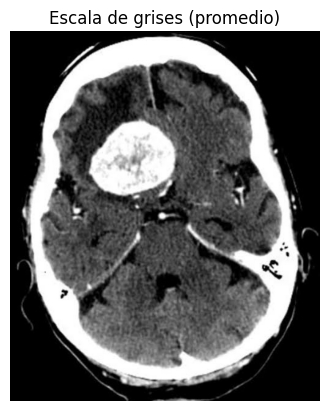

In [4]:
# Convertir a escala de grises promediando canales
gray_avg = ((R.astype(np.float32) + G + B) / 3).astype(np.uint8)

# Mostrar imagen en escala de grises
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')
plt.show()

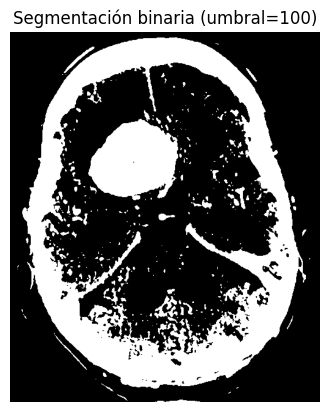

In [5]:
# Umbral para segmentación
umbral = 100
_, segmentada = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen segmentada
plt.imshow(segmentada, cmap='gray')
plt.title(f'Segmentación binaria (umbral={umbral})')
plt.axis('off')
plt.show()

In [8]:
# Cargar imagen y convertir de BGR a RGB
img = cv2.imread('/content/tumor.jpg')  # Cambia el nombre de la imagen
img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

In [9]:
# Normalizar canales entre 0 y 1
R_norm = R.astype(np.float32) / 255
G_norm = G.astype(np.float32) / 255
B_norm = B.astype(np.float32) / 255

# Función objetivo: varianza negativa (porque minimize() minimiza)
def grayscale_variance(weights):
    w_r, w_g, w_b = weights
    gray = w_r * R_norm + w_g * G_norm + w_b * B_norm
    gray_normalized = (gray - gray.min()) / (gray.max() - gray.min())
    return -np.var(gray_normalized)  # Negativo para maximizar

# Restricción: suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Límites de cada peso: entre 0 y 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Valor inicial
initial_weights = [0.33, 0.33, 0.34]

# Optimización
result = minimize(grayscale_variance, initial_weights, method='SLSQP',
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Pesos óptimos:", optimal_weights)

Pesos óptimos: [0.33 0.33 0.34]


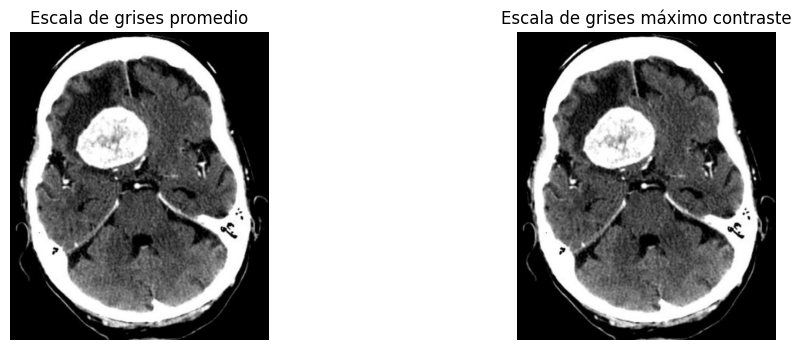

In [11]:
# Crear imagen en escala de grises con pesos óptimos
gray_optimal = optimal_weights[0] * R_norm + optimal_weights[1] * G_norm + optimal_weights[2] * B_norm
gray_optimal = (gray_optimal * 255).astype(np.uint8)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises promedio')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(gray_optimal, cmap='gray')
plt.title('Escala de grises máximo contraste')
plt.axis('off')
plt.show()

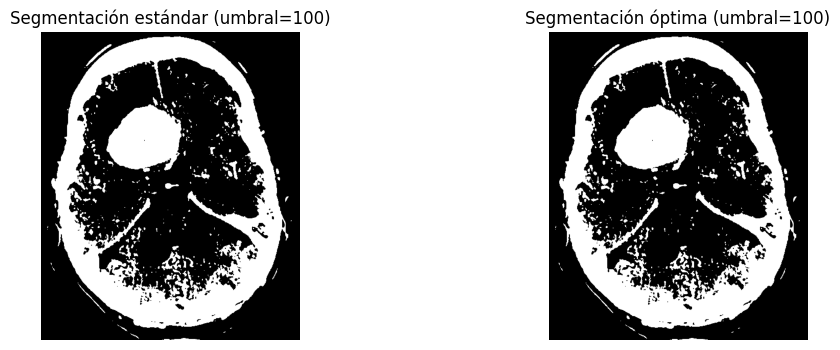

In [12]:
# Segmentar ambas imágenes con un mismo umbral
umbral = 100
_, seg_standard = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)
_, seg_optimal = cv2.threshold(gray_optimal, umbral, 255, cv2.THRESH_BINARY)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(seg_standard, cmap='gray')
plt.title(f'Segmentación estándar (umbral={umbral})')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(seg_optimal, cmap='gray')
plt.title(f'Segmentación óptima (umbral={umbral})')
plt.axis('off')
plt.show()

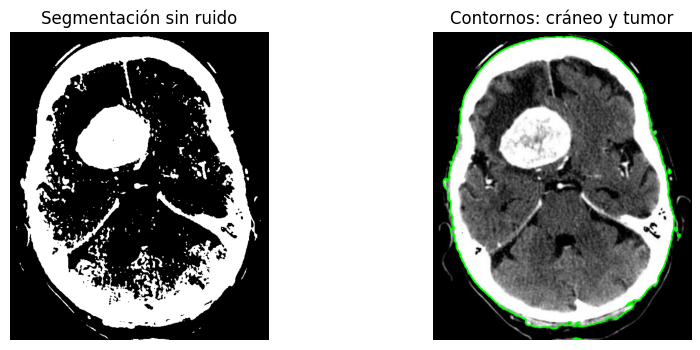

In [13]:
# Importar librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Suponemos que 'seg_optimal' es la imagen segmentada óptimamente
# Aplicar apertura para eliminar ruido pequeño
kernel = np.ones((3, 3), np.uint8)
limpia = cv2.morphologyEx(seg_optimal, cv2.MORPH_OPEN, kernel, iterations=2)

# Encontrar contornos
contornos, _ = cv2.findContours(limpia, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar contornos sobre la imagen original
contorno_img = img_rgb.copy()
cv2.drawContours(contorno_img, contornos, -1, (0, 255, 0), 2)

# Mostrar resultados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(seg_optimal, cmap='gray')
plt.title('Segmentación sin ruido')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(contorno_img)
plt.title('Contornos: cráneo y tumor')
plt.axis('off')
plt.show()

In [15]:
# Asumiendo que el tumor es el contorno más grande después del cráneo
# Ordenar por área y tomar el segundo contorno más grande
areas = [cv2.contourArea(c) for c in contornos]
if len(areas) >= 2:
    idx_tumor = np.argsort(areas)[-2]  # segundo contorno más grande
else:
    idx_tumor = np.argmax(areas)  # único contorno disponible

area_tumor = cv2.contourArea(contornos[idx_tumor])

print(f"Área del tumor (en píxeles cuadrados): {area_tumor}")

Área del tumor (en píxeles cuadrados): 34.0
